In [4]:
import glob
import os
from typing import Any, Dict, List, Tuple, Union

import torch
import yaml
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, VisionDataset

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


import torchvision

In [5]:
device = 'cuda'
lr = 0.0001
num_epoch = 100

input_size = 128 #224//2
batch_size = 128
n_worker = 8

In [6]:
import torchvision.transforms.functional as TF
import random

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 180, 90, 270])

In [7]:
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225])

train_dataset = ImageFolder(
    "/opt/ml/data/train", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        MyRotationTransform(angles=[0, 180, 90, 270]),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = ImageFolder("/opt/ml/data/val", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.Resize(int(input_size/0.875)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

In [8]:
from torch.utils.data.sampler import WeightedRandomSampler

sample_freq = [1169, 4826, 1020, 2655, 4879, 1092] #[0] * len(train_dataset.classes) #df_ff.gender.value_counts().sort_index().to_numpy()
sample_weight = np.concatenate([[1/f]*f for f in sample_freq])
sample_weight = torch.from_numpy(sample_weight)
sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight)//2)

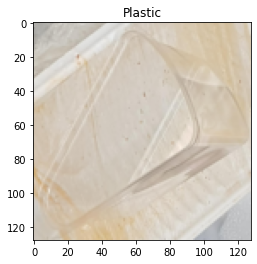

In [9]:
idx = np.random.randint(0, len(train_dataset))
img, label = train_dataset[idx]
img = img.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(img)
plt.title(train_dataset.classes[label])
plt.show()

In [10]:
len(train_dataset), len(val_dataset)

(15641, 5211)

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, drop_last=True, sampler = sampler,
    num_workers=n_worker)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker)

dataloaders = { 'train' : train_loader, 'valid' : val_loader}

In [ ]:
def get_model_teacher():
    # model = torchvision.models.vgg11_bn(pretrained=False)
    # model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=6, bias=True)
    # model.load_state_dict(torch.load('/opt/ml/save/vgg11_bn_adam.pt'))
    model = torchvision.models.vgg11_bn(pretrained=False)
    model.features = model.features[:22]
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=4096, out_features=6, bias=True)
    )

    model.load_state_dict(torch.load('/opt/ml/code/save/vgg11_short_scratch_112_aug.pt'))
    return model

def get_model_student(weight):
    model = torchvision.models.vgg11_bn(pretrained=True)
    model.features = torch.nn.Sequential(*list(model.features[:22]))
    model.avgpool = torch.nn.AvgPool2d(7)
    model.classifier = torch.nn.Sequential(
        #torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=512, out_features=512, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=512, out_features=6, bias=True)
    )
    #model = vgg_basic()
    #model.load_state_dict(torch.load(weight))
    #model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.5, inplace=False), *model.classifier)
    return model

In [ ]:
model_teacher = get_model_teacher().to(device)#.eval()
model_student = get_model_student('/opt/ml/code/save/vgg8_scratch_112_avgpool.pt').to(device) #.eval()

In [37]:
from sklearn.metrics import f1_score

@torch.no_grad()
def validate(model, val_loader):
    
    model.eval()
    
    y_true = []
    y_pred = []
    
    running_cnt = running_loss = running_corrects = 0
    
    for inputs, labels in val_loader:
        inputs = inputs.half().to(device)
        labels = labels.half().to(device)
        #inputs = torch.nn.functional.interpolate(inputs, size=112, mode='bilinear', align_corners=False)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        #loss = criterion(outputs, labels)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())

        running_cnt += inputs.size(0)
        #running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    #epoch_loss = running_loss / running_cnt
    epoch_acc = running_corrects.double() / running_cnt
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, f1))


In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from model import CustomVGGHalf

model_student = CustomVGGHalf().to(device)
model_student.load_state_dict(torch.load('save/vgg9_fp16.pt'))
model_student.eval()
validate(model_student, val_loader)

Acc: 0.8202 F1: 0.7988


**bias=True**  
save/vgg9_112.pt : Acc: 0.8169 F1: 0.7940  
save/vgg9_112_reg.pt : Acc: 0.8202 F1: 0.7987  

**bias=False**  
save/vgg9_128_base.pt :Acc: 0.8144 F1: 0.7886  
save/vgg9_128_regulerized_1e-4.pt : Acc: 0.8108 F1: 0.7920  

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_student.parameters(), lr=lr)
lr_scheduler =   optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5, factor=0.32) # optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=0.000001)#

In [ ]:
from trainer_kd import TrainerKD

trainer = TrainerKD('/opt/ml/code/save', seed=42)

In [ ]:
trainer.train(model_teacher, model_student, dataloaders, criterion, optimizer, lr_scheduler, num_epoch, 10, 10, 0.5, 'kd_resnet50_vgg8_01')

#odel_teacher, model_student, dataloaders, criterion, optimizer, lr_scheduler, max_epoch, patience, T, weight, save_name='best', sub_dir=None

In [ ]:
model_student